In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("application_train.csv")

# Exploratory Data Analysis
---
In this section we look forward to better understand our data through plots and summary statistics. We start by simply looking at the head of our data set.

In [3]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We immediately want to know if there are missing values and how many of them, since this will make us choose how to handle them.

In [4]:
nan_informations = pd.DataFrame(index = data.columns)
nan_informations["PERCENTAGE_MISSING_VALUES"] = data.isnull().sum() / len(data)
nan_informations.sort_values(by = "PERCENTAGE_MISSING_VALUES", ascending = False)

,PERCENTAGE_MISSING_VALUES
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
...,...
NAME_HOUSING_TYPE,0.000000
NAME_FAMILY_STATUS,0.000000
NAME_EDUCATION_TYPE,0.000000
NAME_INCOME_TYPE,0.000000


We see there a lot of missing values, with some features even touching peaks of nearly 70%.

Now let's take a look at the distribution of our TARGET feature.

[Text(0, 0.5, 'Counts'), Text(0.5, 0, 'TARGET')]

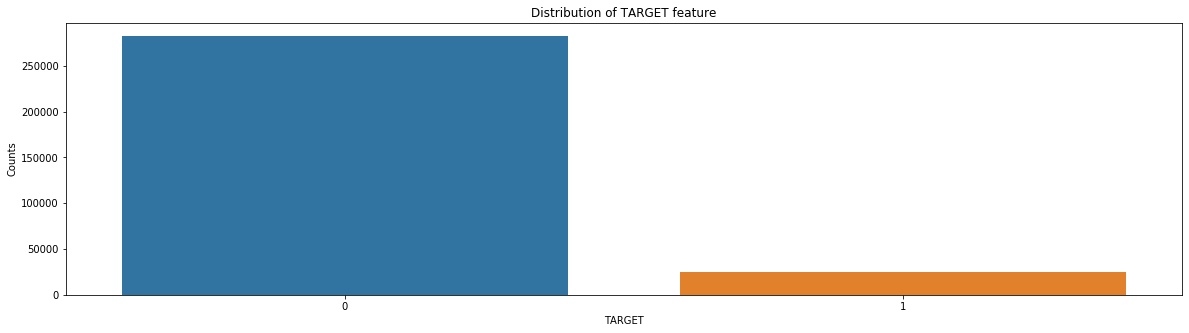

In [5]:
distribution_target = data[["SK_ID_CURR", "TARGET"]].groupby(by = "TARGET").count()

plt.figure(figsize = (20, 5))
figure = sns.barplot(x = [0, 1], y = "SK_ID_CURR", data = distribution_target)
figure.set_title("Distribution of TARGET feature")
figure.set(xlabel = "TARGET", ylabel = "Counts")

We see that there are a lot more observation with TARGET value 0 then ones with TARGET value 1. This is an information which could reveal useful later on.

Now we want to show some distributions on features that we think could be of value.

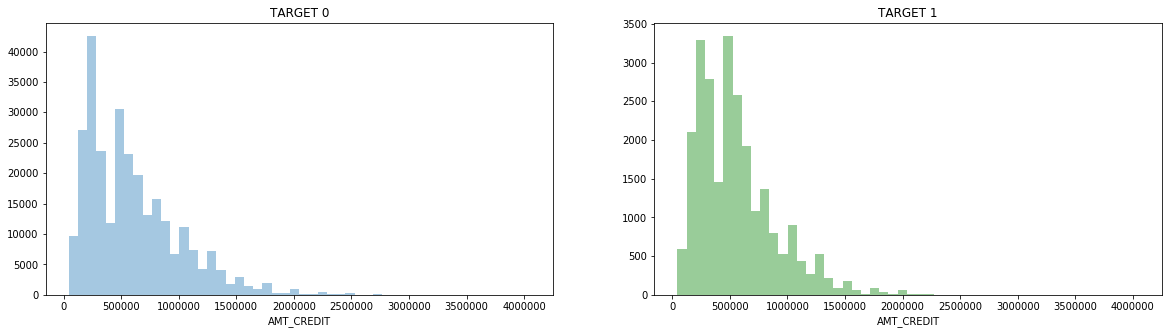

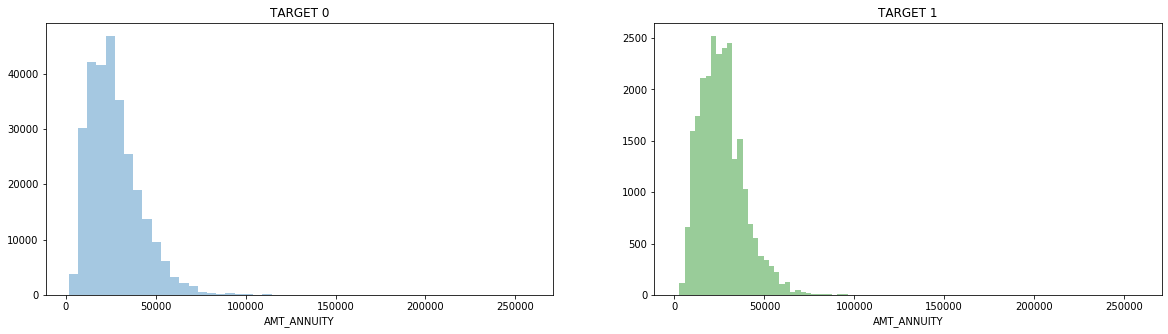

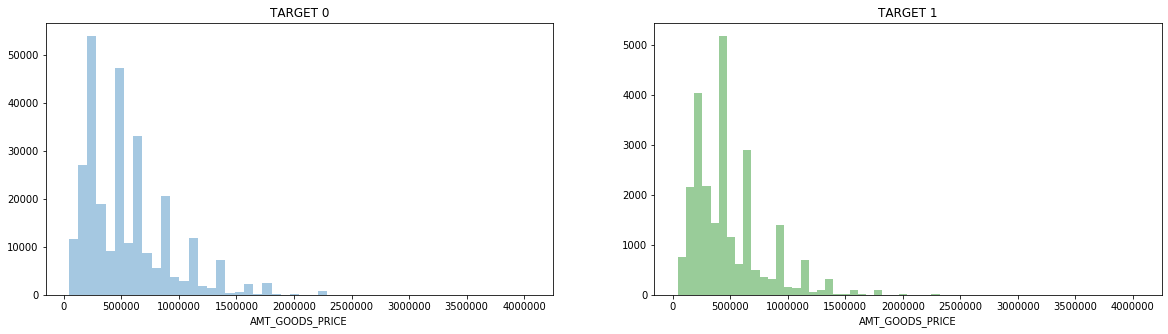

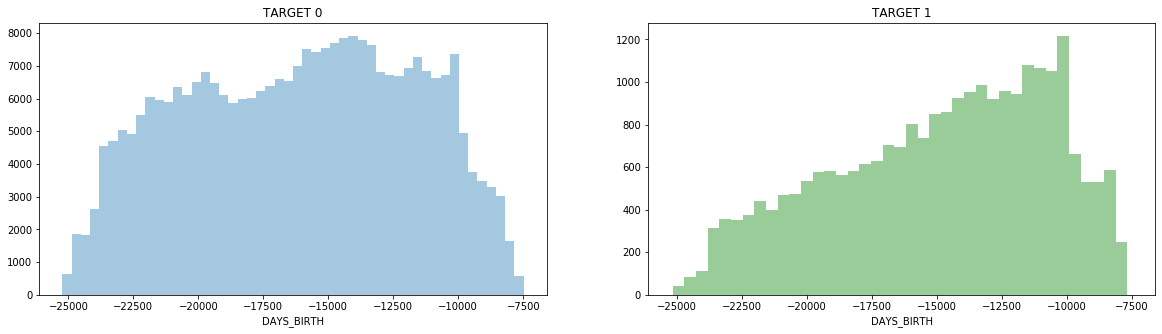

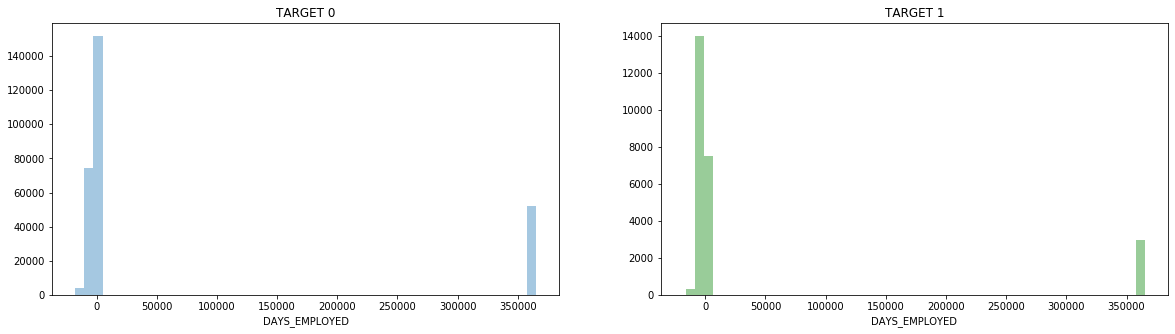

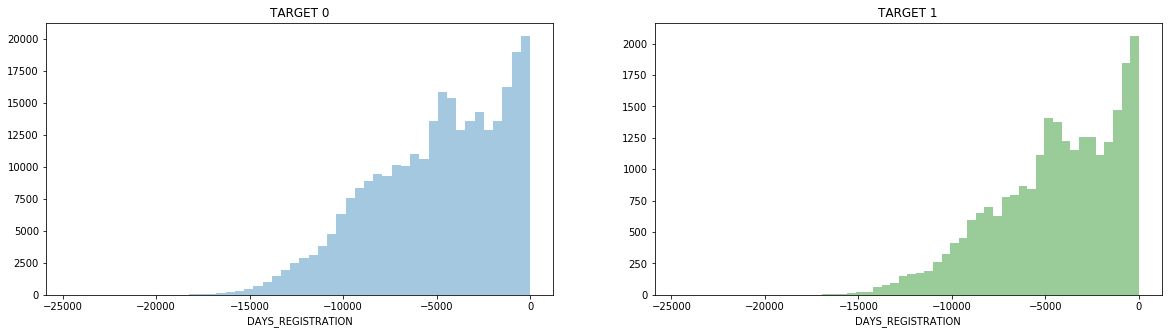

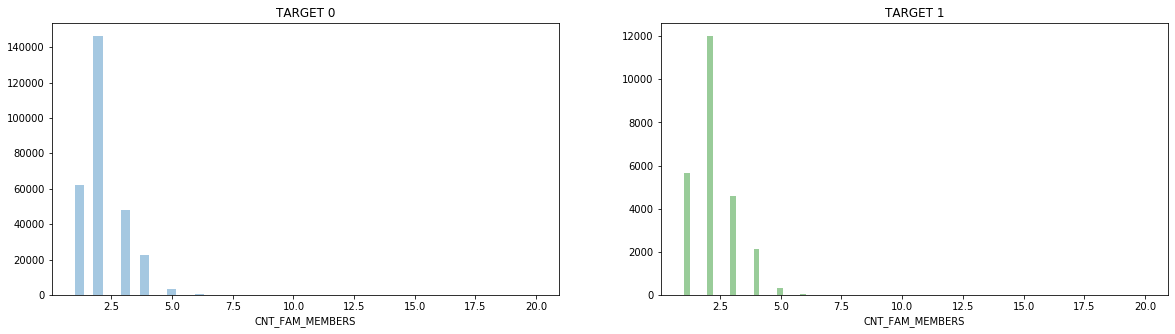

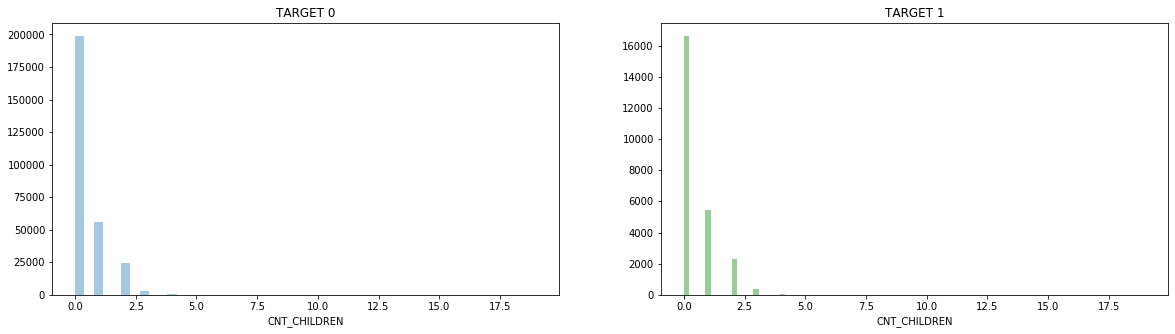

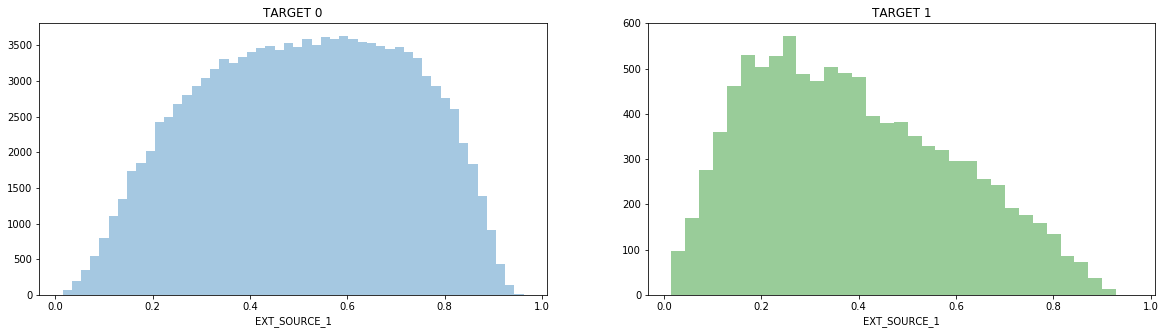

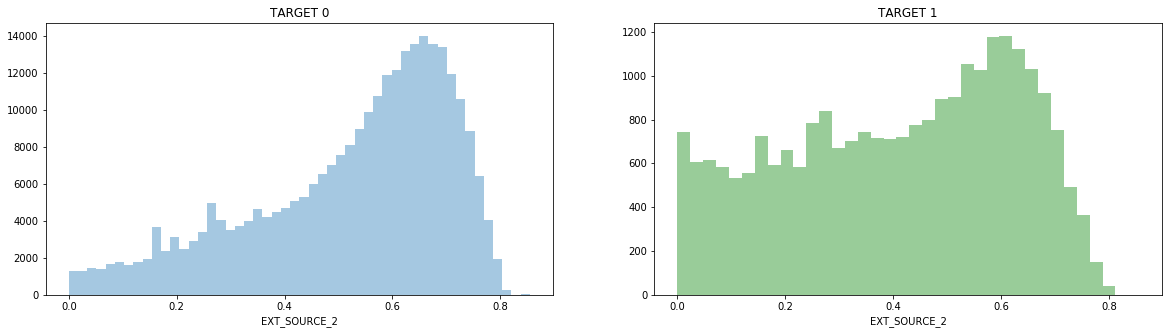

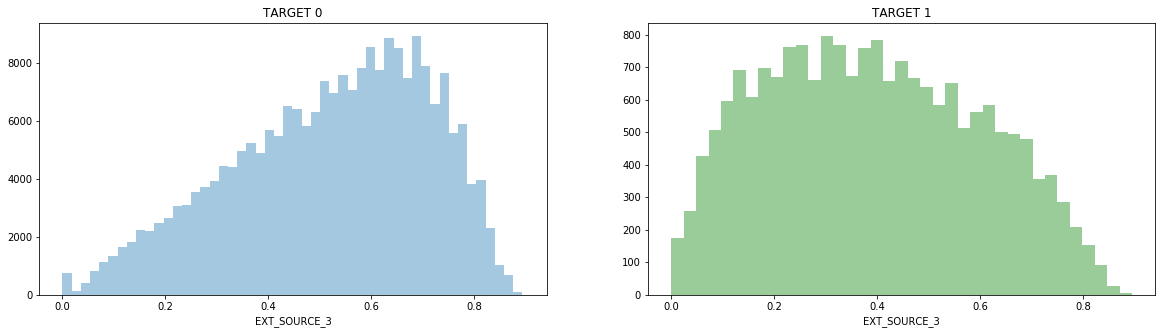

In [6]:
def show_distributions(data, target_feature, features):
    data_zero = data[data[target_feature] == 0]
    data_one = data[data[target_feature] == 1]
    for feature in features:
        _, figure = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
        figure[0].set_title("TARGET 0")
        figure[1].set_title("TARGET 1")
        sns.distplot(data_zero[feature].dropna(), ax = figure[0], kde = False)
        sns.distplot(data_one[feature].dropna(), ax = figure[1], kde = False, color = "g")

show_distributions(data, "TARGET", ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "CNT_FAM_MEMBERS", "CNT_CHILDREN", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"])

We can get a bunch of informations looking at the graphs. First of all DAYS_BIRTH, EXT_SOURCE_1, EXT_SOURCE_2 and EXT_SOURCE_3 seem all to be relevant parameters in determining whether or not a client will repay the loan.

Second there's clearly a problem concerning DAYS_EMPLOYED since there are values of more than 300'000 days, i.e. more than 900 years! We must get rid of these clearly erroneous values.

In [7]:
set(data[data["DAYS_EMPLOYED"] > 200000]["DAYS_EMPLOYED"])

{365243}

In [8]:
data = data.replace({365243 : np.nan})

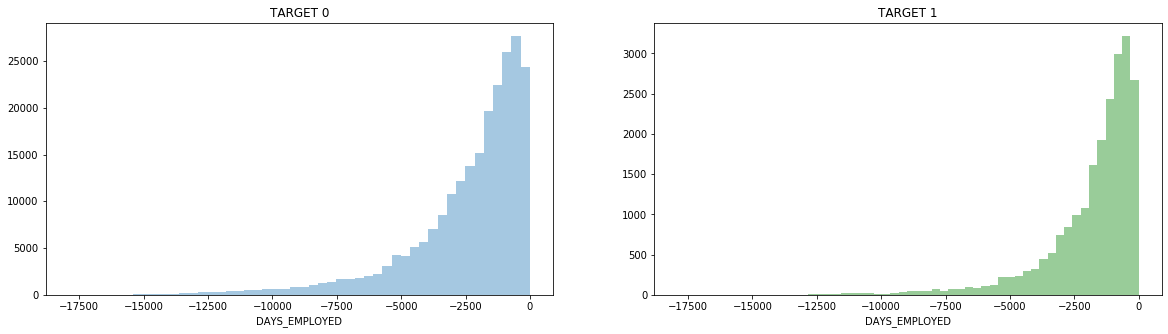

In [9]:
show_distributions(data, "TARGET", ["DAYS_EMPLOYED"])

Now everything looks more plausible.

# Feature Engineering - Base Data Set
---
Here is probably the most important section of the project. We're going to select, transform and create features in order to improve our data. The final score (maybe computed using a kfold model evaluation) will be a good posteriori measure of how good our feature engineering was.

Let's start by creating new features based on what we have in our first data set. We'll proceed by sections (or "themes").

### Credit

We have information about credit and annuity, these are absolute values but in reality it makes sense to know how much the annuity is compared to the credit, so let's create a feature that tells us exactly this.

In [10]:
data["PERCENTAGE_ANNUITY_CREDIT"] = data["AMT_ANNUITY"] / data["AMT_CREDIT"]

Another feature could tell us how the AMT_ANNUITY compares to the AMT_TOTAL_INCOME of the client. This seems a strong measure of the client's ability to repay or not a loan.

In [11]:
data["PERCENTAGE_ANNUITY"] = data["AMT_ANNUITY"] / data["AMT_INCOME_TOTAL"]

Now we add a feature which will tell us how the asked credit compares to the good price.

In [12]:
data["PERCENTAGE_GOODS_PRICE"] = data["AMT_GOODS_PRICE"] / data["AMT_CREDIT"]

### Personal informations
We have parameters CNT_CHILDREN and CNT_FAM_MEMBERS. We want to split them in CNT_CHILDREN and CNT_FAM_NOT_CHILDREN.

In [13]:
data["CNT_FAM_NOT_CHILDREN"] = data["CNT_FAM_MEMBERS"] - data["CNT_CHILDREN"]

In [14]:
set(data["CNT_FAM_NOT_CHILDREN"])

{nan, 1.0, 2.0, nan}

Since we have only two values of them let's transform it to a 0 - 1 parameter.

In [15]:
def convert_quick(x):
    if(np.isnan(x)):
        return(np.nan)
    if(x == 1.0):
        return(0)
    else:
        return(1)

data["CNT_FAM_NOT_CHILDREN"] = list(map(convert_quick, data["CNT_FAM_NOT_CHILDREN"]))

In [16]:
data.drop(["CNT_FAM_MEMBERS"], axis = 1, inplace = True)

We have DAYS_BIRTH and DAYS_EMPLOYED, we add a feature to see how many days the client has worked compared to his entire life.

In [17]:
data["DAYS_BIRTH"] = -data["DAYS_BIRTH"]
data["DAYS_EMPLOYED"] = -data["DAYS_EMPLOYED"]

In [18]:
data["PERCENTAGE_EMPLOYED"] = data["DAYS_EMPLOYED"] / data["DAYS_BIRTH"]

# Feature Engineering - Other data sets
---
Here we continue our feature engineering section, but we're going to use other data sets rather than just the base one.

Let's start by defining a general function for "merging" external data sets to the base one. Since external data sets can contain more observations referring to the same client we need to get a kind of "mean" out of them.

In [19]:
def merge_external(data, ext_data, id_to_remove, name_ext):
    ext_data.drop([id_to_remove], axis = 1, inplace = True)
    ext_data = pd.get_dummies(ext_data)
    ext_data = ext_data.groupby(by = "SK_ID_CURR").mean().reset_index()
    ids = ext_data["SK_ID_CURR"]
    ext_data.drop(["SK_ID_CURR"], axis = 1, inplace = True)
    ext_data.columns = [name_ext + "_" + feature for feature in ext_data.columns]
    ext_data["SK_ID_CURR"] = ids
    return(data.merge(ext_data, on = "SK_ID_CURR"))

### Bureau data

We try to get informations from the Bureau dataset. We join the two datasets with our previous function.

In [20]:
bureau_data = pd.read_csv("bureau.csv")

In [21]:
data = merge_external(data, bureau_data, "SK_ID_BUREAU", "BUREAU")

In [25]:
del(bureau_data)

### Previous Applications data

In [22]:
previous_data = pd.read_csv("previous_application.csv")

In [23]:
data = merge_external(data, previous_data, "SK_ID_PREV", "PREV")

In [26]:
del(previous_data)

### Installments Payments data

In [24]:
installments_data = pd.read_csv("installments_payments.csv")

In [29]:
data = merge_external(data, installments_data, "SK_ID_PREV", "INSTALLMENTS")

In [31]:
data.to_csv("worked_data_train.csv")